In [10]:
print("hello world")

hello world


Training a CNN for multi-class multi-labeling classification (MCMLC) on 512*512*3 retinal images over the 3 mains labels beeing DR, MH, ODC according to the EDA. 

In [11]:
import os
import pandas as pd

import torch
import torch.nn as nn
from torchvision import transforms
from sklearn.model_selection import train_test_split

# Local imports
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
# print(parent_dir)
tool_path = os.path.abspath(os.path.normpath(parent_dir))
if tool_path not in sys.path:
    sys.path.insert(0, tool_path)


from tools.data_tools import crop_image_tensor
from tools.model_tools import validate, train_and_test_model
from tools.visualization_tools import plot_training_statistics
from classes.RetinaDataset import RetinaDataset
from classes.CNNMultiClassMultiLabeling import CNNMultiClassMultiLabeling

# 1. Data Transformation

In [12]:
# Appliquer les transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((512, 512)),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


## 2. Data Loading


In [ ]:
train_dataset = RetinaDataset(
    root_dir='../../data/Training-Set/Training',
    csv_file='../../data/Training-Set/Training_Labels.csv',
    transform=transform,
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"],
    add_normal_label=True
)

test_dataset = RetinaDataset(
    root_dir='../../data/Test-Set/Test',
    csv_file='../../data/Test-Set/Testing_Labels.csv',
    transform=transform,
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"],
    add_normal_label=True
)

val_dataset = RetinaDataset(
    root_dir='../../data/Evaluation-Set/Validation',
    csv_file='../../data/Evaluation-Set/Validation_Labels.csv',
    transform=transform,
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"],
    add_normal_label=True
)


In [15]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)


## 3. Model init

In [16]:
# Initialisation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNMultiClassMultiLabeling(number_of_classes=4).to(device) # ["DR", "MH", "ODC"] and normal

## 4. Fonction de perte et métriques

In [17]:
criterion = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 5. Entrainement du modèle

### A. Paramétrage

In [18]:
# Early stopping
patience = 5  
min_delta = 0.001  
best_train_loss = float('inf')
counter = 0

# Stockage des métriques
training_statistics = {
    'epoch': [],
    'train_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'test_accuracies': [],
    'test_f1s': [],
    'train_f1s': [],
    'train_roc_aucs': [],
    'test_roc_aucs': []
}

num_epochs = 30  

### B. Entrainement

In [19]:
for epoch in range(num_epochs):
    print(f"Epoch number: {epoch}")

    # Training and evaluation
    train_loss, train_accuracy, train_f1, train_roc_auc, test_loss, test_accuracy, test_f1, test_roc_auc = train_and_test_model(
        model=model, 
        train_loader=train_loader,
        test_loader=test_loader,
        optimizer=optimizer, 
        criterion=criterion, 
        device=device)
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Train F1-score: {train_f1:.4f} | Train ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f} | Test F1-score: {test_f1:.4f} | Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Used GPU VRAM: {torch.cuda.memory_allocated() / 1024**3:.2f} Go")

    # Early stopping
    if epoch > 5:
        if (best_train_loss - train_loss) > min_delta:
            best_train_loss = train_loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"Early stopping à l'epoch {epoch}")
            break

    # Metrics storage
    training_statistics['epoch'].append(epoch)
    training_statistics['train_losses'].append(train_loss)
    training_statistics['train_accuracies'].append(train_accuracy)
    training_statistics['train_f1s'].append(train_f1)
    training_statistics['train_roc_aucs'].append(train_roc_auc)
    training_statistics['test_losses'].append(test_loss)
    training_statistics['test_accuracies'].append(test_accuracy)
    training_statistics['test_f1s'].append(test_f1)
    training_statistics['test_roc_aucs'].append(test_roc_auc)
    torch.cuda.empty_cache()
    print("="*70)

Epoch number: 0


100%|██████████| 40/40 [01:41<00:00,  2.55s/it]


Train Loss: 3.7339 | Train Accuracy: 0.1655 | Train F1-score: 0.3463 | Train ROC-AUC: 0.5500
Test Loss: 0.5698 | Test Accuracy: 0.3171 | Test F1-score: 0.3834 | Test ROC-AUC: 0.6007
Used GPU VRAM: 2.02 Go
Epoch number: 1


100%|██████████| 40/40 [01:31<00:00,  2.30s/it]


Train Loss: 0.6112 | Train Accuracy: 0.2227 | Train F1-score: 0.3536 | Train ROC-AUC: 0.5774
Test Loss: 0.5238 | Test Accuracy: 0.3463 | Test F1-score: 0.4524 | Test ROC-AUC: 0.6395
Used GPU VRAM: 2.02 Go
Epoch number: 2


100%|██████████| 40/40 [01:28<00:00,  2.22s/it]


Train Loss: 0.6035 | Train Accuracy: 0.2557 | Train F1-score: 0.3609 | Train ROC-AUC: 0.5860
Test Loss: 0.5441 | Test Accuracy: 0.2951 | Test F1-score: 0.3852 | Test ROC-AUC: 0.6081
Used GPU VRAM: 2.02 Go
Epoch number: 3


100%|██████████| 40/40 [01:27<00:00,  2.18s/it]


Train Loss: 0.6080 | Train Accuracy: 0.1396 | Train F1-score: 0.2334 | Train ROC-AUC: 0.5496
Test Loss: 0.5491 | Test Accuracy: 0.2415 | Test F1-score: 0.3636 | Test ROC-AUC: 0.6069
Used GPU VRAM: 2.02 Go
Epoch number: 4


100%|██████████| 40/40 [01:26<00:00,  2.16s/it]


Train Loss: 0.5932 | Train Accuracy: 0.1027 | Train F1-score: 0.1761 | Train ROC-AUC: 0.5358
Test Loss: 0.5312 | Test Accuracy: 0.2780 | Test F1-score: 0.3974 | Test ROC-AUC: 0.6182
Used GPU VRAM: 2.02 Go
Epoch number: 5


100%|██████████| 40/40 [01:25<00:00,  2.15s/it]


Train Loss: 0.5557 | Train Accuracy: 0.1906 | Train F1-score: 0.2966 | Train ROC-AUC: 0.5771
Test Loss: 0.5017 | Test Accuracy: 0.3244 | Test F1-score: 0.4288 | Test ROC-AUC: 0.6293
Used GPU VRAM: 2.02 Go
Epoch number: 6


100%|██████████| 40/40 [01:26<00:00,  2.16s/it]


Train Loss: 0.5664 | Train Accuracy: 0.1357 | Train F1-score: 0.2188 | Train ROC-AUC: 0.5535
Test Loss: 0.4988 | Test Accuracy: 0.3171 | Test F1-score: 0.4523 | Test ROC-AUC: 0.6436
Used GPU VRAM: 2.02 Go
Epoch number: 7


100%|██████████| 40/40 [01:26<00:00,  2.16s/it]


Train Loss: 0.5487 | Train Accuracy: 0.1663 | Train F1-score: 0.2791 | Train ROC-AUC: 0.5756
Test Loss: 0.4516 | Test Accuracy: 0.4098 | Test F1-score: 0.5282 | Test ROC-AUC: 0.6784
Used GPU VRAM: 2.02 Go
Epoch number: 8


100%|██████████| 40/40 [01:26<00:00,  2.16s/it]


Train Loss: 0.5797 | Train Accuracy: 0.1035 | Train F1-score: 0.1922 | Train ROC-AUC: 0.5471
Test Loss: 0.4907 | Test Accuracy: 0.3634 | Test F1-score: 0.4572 | Test ROC-AUC: 0.6416
Used GPU VRAM: 2.02 Go
Epoch number: 9


100%|██████████| 40/40 [01:26<00:00,  2.16s/it]


Train Loss: 0.5599 | Train Accuracy: 0.1020 | Train F1-score: 0.1790 | Train ROC-AUC: 0.5434
Test Loss: 0.4875 | Test Accuracy: 0.2805 | Test F1-score: 0.4093 | Test ROC-AUC: 0.6252
Used GPU VRAM: 2.02 Go
Epoch number: 10


100%|██████████| 40/40 [01:26<00:00,  2.16s/it]


Train Loss: 0.5335 | Train Accuracy: 0.1608 | Train F1-score: 0.2620 | Train ROC-AUC: 0.5692
Test Loss: 0.4918 | Test Accuracy: 0.3122 | Test F1-score: 0.4142 | Test ROC-AUC: 0.6257
Used GPU VRAM: 2.02 Go
Epoch number: 11


100%|██████████| 40/40 [01:26<00:00,  2.16s/it]


Train Loss: 0.5249 | Train Accuracy: 0.1898 | Train F1-score: 0.3083 | Train ROC-AUC: 0.5866
Test Loss: 0.4928 | Test Accuracy: 0.4000 | Test F1-score: 0.4749 | Test ROC-AUC: 0.6485
Used GPU VRAM: 2.02 Go
Epoch number: 12


100%|██████████| 40/40 [01:26<00:00,  2.15s/it]


Train Loss: 0.5236 | Train Accuracy: 0.1835 | Train F1-score: 0.2928 | Train ROC-AUC: 0.5803
Test Loss: 0.4731 | Test Accuracy: 0.3268 | Test F1-score: 0.4477 | Test ROC-AUC: 0.6419
Used GPU VRAM: 2.02 Go
Epoch number: 13


100%|██████████| 40/40 [01:27<00:00,  2.19s/it]


Train Loss: 0.5259 | Train Accuracy: 0.1812 | Train F1-score: 0.2855 | Train ROC-AUC: 0.5776
Test Loss: 0.4908 | Test Accuracy: 0.2659 | Test F1-score: 0.3701 | Test ROC-AUC: 0.6089
Used GPU VRAM: 2.02 Go
Epoch number: 14


100%|██████████| 40/40 [01:26<00:00,  2.17s/it]


Train Loss: 0.5201 | Train Accuracy: 0.1835 | Train F1-score: 0.2859 | Train ROC-AUC: 0.5783
Test Loss: 0.4833 | Test Accuracy: 0.2976 | Test F1-score: 0.4111 | Test ROC-AUC: 0.6248
Used GPU VRAM: 2.02 Go
Epoch number: 15


100%|██████████| 40/40 [01:27<00:00,  2.19s/it]


Train Loss: 0.5089 | Train Accuracy: 0.1906 | Train F1-score: 0.3040 | Train ROC-AUC: 0.5848
Test Loss: 0.4384 | Test Accuracy: 0.3902 | Test F1-score: 0.5247 | Test ROC-AUC: 0.6771
Used GPU VRAM: 2.02 Go
Epoch number: 16


100%|██████████| 40/40 [01:27<00:00,  2.19s/it]


Train Loss: 0.5043 | Train Accuracy: 0.2290 | Train F1-score: 0.3490 | Train ROC-AUC: 0.6007
Test Loss: 0.5079 | Test Accuracy: 0.1805 | Test F1-score: 0.2888 | Test ROC-AUC: 0.5809
Used GPU VRAM: 2.02 Go
Epoch number: 17


100%|██████████| 40/40 [01:27<00:00,  2.18s/it]


Train Loss: 0.5159 | Train Accuracy: 0.1655 | Train F1-score: 0.2618 | Train ROC-AUC: 0.5701
Test Loss: 0.4529 | Test Accuracy: 0.3463 | Test F1-score: 0.4738 | Test ROC-AUC: 0.6531
Used GPU VRAM: 2.02 Go
Epoch number: 18


100%|██████████| 40/40 [01:27<00:00,  2.18s/it]


Train Loss: 0.5005 | Train Accuracy: 0.2078 | Train F1-score: 0.3210 | Train ROC-AUC: 0.5905
Test Loss: 0.4611 | Test Accuracy: 0.2878 | Test F1-score: 0.4211 | Test ROC-AUC: 0.6318
Used GPU VRAM: 2.02 Go
Epoch number: 19


100%|██████████| 40/40 [01:27<00:00,  2.19s/it]


Train Loss: 0.4929 | Train Accuracy: 0.2212 | Train F1-score: 0.3444 | Train ROC-AUC: 0.5998
Test Loss: 0.4274 | Test Accuracy: 0.4415 | Test F1-score: 0.5457 | Test ROC-AUC: 0.6872
Used GPU VRAM: 2.02 Go
Epoch number: 20


100%|██████████| 40/40 [01:26<00:00,  2.17s/it]


Train Loss: 0.4986 | Train Accuracy: 0.2447 | Train F1-score: 0.3707 | Train ROC-AUC: 0.6108
Test Loss: 0.4630 | Test Accuracy: 0.4317 | Test F1-score: 0.5176 | Test ROC-AUC: 0.6719
Used GPU VRAM: 2.02 Go
Epoch number: 21


100%|██████████| 40/40 [01:26<00:00,  2.17s/it]


Train Loss: 0.4720 | Train Accuracy: 0.2808 | Train F1-score: 0.4148 | Train ROC-AUC: 0.6268
Test Loss: 0.4657 | Test Accuracy: 0.2902 | Test F1-score: 0.4060 | Test ROC-AUC: 0.6243
Used GPU VRAM: 2.02 Go
Epoch number: 22


100%|██████████| 40/40 [01:27<00:00,  2.18s/it]


Train Loss: 0.4797 | Train Accuracy: 0.2196 | Train F1-score: 0.3297 | Train ROC-AUC: 0.5947
Test Loss: 0.4517 | Test Accuracy: 0.3390 | Test F1-score: 0.4554 | Test ROC-AUC: 0.6444
Used GPU VRAM: 2.02 Go
Epoch number: 23


100%|██████████| 40/40 [01:29<00:00,  2.23s/it]


Train Loss: 0.4683 | Train Accuracy: 0.2369 | Train F1-score: 0.3553 | Train ROC-AUC: 0.6047
Test Loss: 0.4639 | Test Accuracy: 0.3317 | Test F1-score: 0.4352 | Test ROC-AUC: 0.6329
Used GPU VRAM: 2.02 Go
Epoch number: 24


100%|██████████| 40/40 [01:26<00:00,  2.17s/it]


Train Loss: 0.4897 | Train Accuracy: 0.2102 | Train F1-score: 0.3228 | Train ROC-AUC: 0.5925
Test Loss: 0.5063 | Test Accuracy: 0.3268 | Test F1-score: 0.4091 | Test ROC-AUC: 0.6187
Used GPU VRAM: 2.02 Go
Epoch number: 25


100%|██████████| 40/40 [01:33<00:00,  2.34s/it]


Train Loss: 0.4923 | Train Accuracy: 0.2102 | Train F1-score: 0.3238 | Train ROC-AUC: 0.5926
Test Loss: 0.5142 | Test Accuracy: 0.4293 | Test F1-score: 0.5238 | Test ROC-AUC: 0.6752
Used GPU VRAM: 2.02 Go
Epoch number: 26


100%|██████████| 40/40 [01:31<00:00,  2.29s/it]


Train Loss: 0.4743 | Train Accuracy: 0.2690 | Train F1-score: 0.3998 | Train ROC-AUC: 0.6210
Test Loss: 0.4536 | Test Accuracy: 0.3268 | Test F1-score: 0.4571 | Test ROC-AUC: 0.6459
Used GPU VRAM: 2.02 Go
Epoch number: 27


100%|██████████| 40/40 [01:27<00:00,  2.20s/it]


Train Loss: 0.4843 | Train Accuracy: 0.2353 | Train F1-score: 0.3675 | Train ROC-AUC: 0.6073
Test Loss: 0.4532 | Test Accuracy: 0.3244 | Test F1-score: 0.4498 | Test ROC-AUC: 0.6425
Used GPU VRAM: 2.02 Go
Epoch number: 28


100%|██████████| 40/40 [01:32<00:00,  2.32s/it]


Train Loss: 0.4812 | Train Accuracy: 0.2337 | Train F1-score: 0.3640 | Train ROC-AUC: 0.6075
Test Loss: 0.4659 | Test Accuracy: 0.3610 | Test F1-score: 0.4792 | Test ROC-AUC: 0.6533
Used GPU VRAM: 2.02 Go
Early stopping à l'epoch 28


In [20]:
torch.save(model.state_dict(), '../Models/model_simple_cnn_mcmlc_retina.pth')

In [21]:
training_statistics_df = pd.DataFrame(training_statistics)
training_statistics_df.to_csv('../Training-Statistics/ts_simple_cnn_mcmlc_retina.csv', index=False)

## 6. Evolution of the training

In [22]:
training_statistics_df = pd.read_csv('../Training-Statistics/ts_simple_cnn_mcmlc_retina.csv')

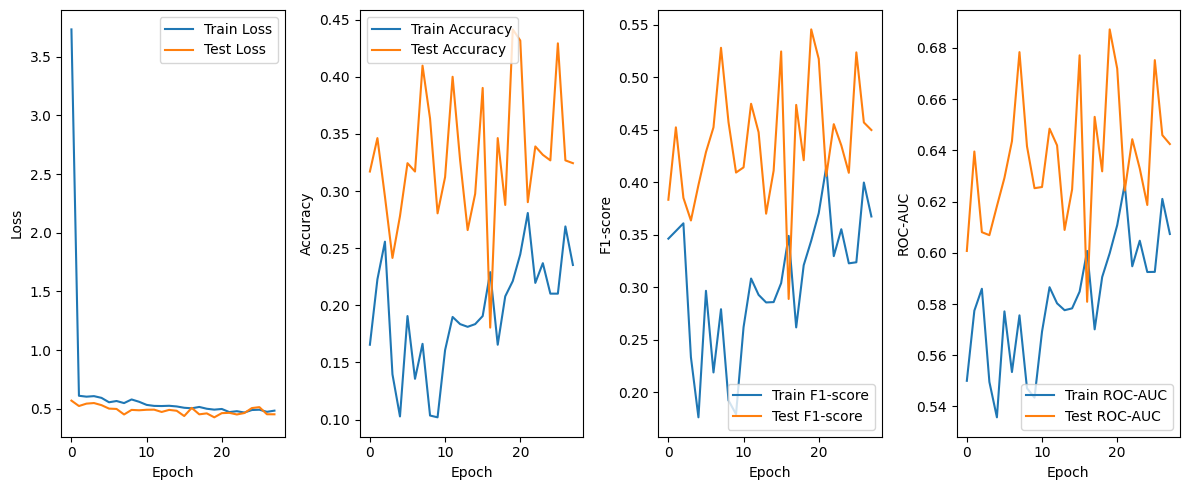

In [23]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_simple_cnn_mcmlc_retina_zoomed.png',
    title='Training Evolution - Simple CNN Multi-Class Multi-Labeling',
    zoomed=True
)

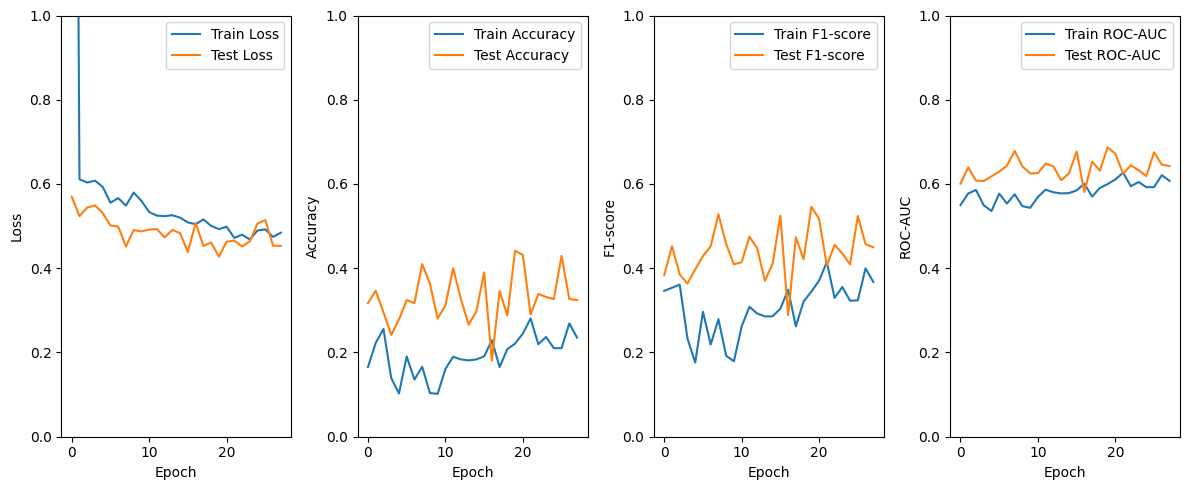

In [24]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_simple_cnn_mcmlc_retina.png',
    title='Training Evolution - Simple CNN Multi-Class Multi-Labeling',
    zoomed=False
)

In [15]:
print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

torch.cuda.memory_allocated: 2.019200GB
torch.cuda.memory_reserved: 6.089844GB
torch.cuda.max_memory_reserved: 6.904297GB


## 7. Model evaluation

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNMultiClassMultiLabeling(number_of_classes=4).to(device)
model.load_state_dict(torch.load('../Models/model_simple_cnn_mcmlc_retina.pth', weights_only=True))
criterion = nn.BCEWithLogitsLoss() 

In [17]:
val_loss, val_accuracy, val_f1, val_roc_auc = validate(model, val_loader, criterion, device)

In [18]:
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | Validation F1-score: {val_f1:.4f} | Validation ROC-AUC: {val_roc_auc:.4f}")

Validation Loss: 0.4985 | Validation Accuracy: 0.5828 | Validation F1-score: 0.5656 | Validation ROC-AUC: 0.7037


Results are very bad..